In [1]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import torch
import copy

In [2]:
sys.path.append("../../WatChMaL_analysis_copy")
sys.path.append('../../WatChMaL_analysis_copy/WatChMaL')

In [3]:
from WatChMaL.watchmal.dataset.cnn_mpmt.cnn_mpmt_dataset import CNNmPMTDataset

<h1>Define Plotting Functions</h1>

In [4]:
def plot_event(data, mpmt_pos, old_convention=False, title=None, style="default", cmap=plt.cm.jet, vertical_partition=False,
              padded=False, horizontal_partition=False):
    cmap = copy.copy(cmap)
    if style=="dark_background":
        edgecolor='0.15'
        cmap.set_bad(color='black')
    else:
        edgecolor='0.85'
        cmap.set_bad(color='white')
    data[data==0] = np.nan
    indices = np.indices(data.shape)
    channels = indices[0].flatten()
    positions = indices[1:].reshape(2,-1).astype(np.float64)
    positions += channel_to_position(channels)
    if old_convention:
        positions[1] = max(mpmt_pos[:, 1])-positions[1]
    mpmts = [Circle((pos[1], pos[0]), radius=0.47)
             for pos in mpmt_pos]
    with plt.style.context(style):
        if old_convention:
            figsize = (20,16)
        elif padded:
            figsize = (25,10)
        else:
            figsize = (20,12)
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.add_collection(PatchCollection(mpmts, facecolor='none', linewidths=1, edgecolors=edgecolor))
        pmts = ax.scatter(positions[1], positions[0], c=data.flatten(), s=3, cmap=cmap)
        plt.colorbar(pmts)
    if title is not None:
        ax.set_title(title)
    
    #New
    if vertical_partition:
        plt.axvline(x=data.shape[2]-1, c='r')
    
    if horizontal_partition:
        plt.axhline(y=data.shape[1]-1, c='r')

In [5]:
def channel_to_position(channel):
    channel = channel % 19 
    theta = (channel<12)*2*np.pi*channel/12 + ((channel >= 12) & (channel<18))*2*np.pi*(channel-12)/6
    radius = 0.2*(channel<18)+0.2*(channel<12)
    position = [radius*np.cos(theta), radius*np.sin(theta)] # note this is [y, x] or [row, column]
    return position

<h1>Load Data</h1>

In [6]:
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"
data_file = h5py.File(data_path, "r")

In [7]:
data_file.keys()

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>

In [8]:
np.array(data_file['positions']).shape

(23481549, 1, 3)

The mPMT positions file must include IWCDshort for the short tank data. 

In [9]:
data_obj = CNNmPMTDataset(data_path, '/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz', is_distributed=False)

<h1>Visualizing the Data</h1>

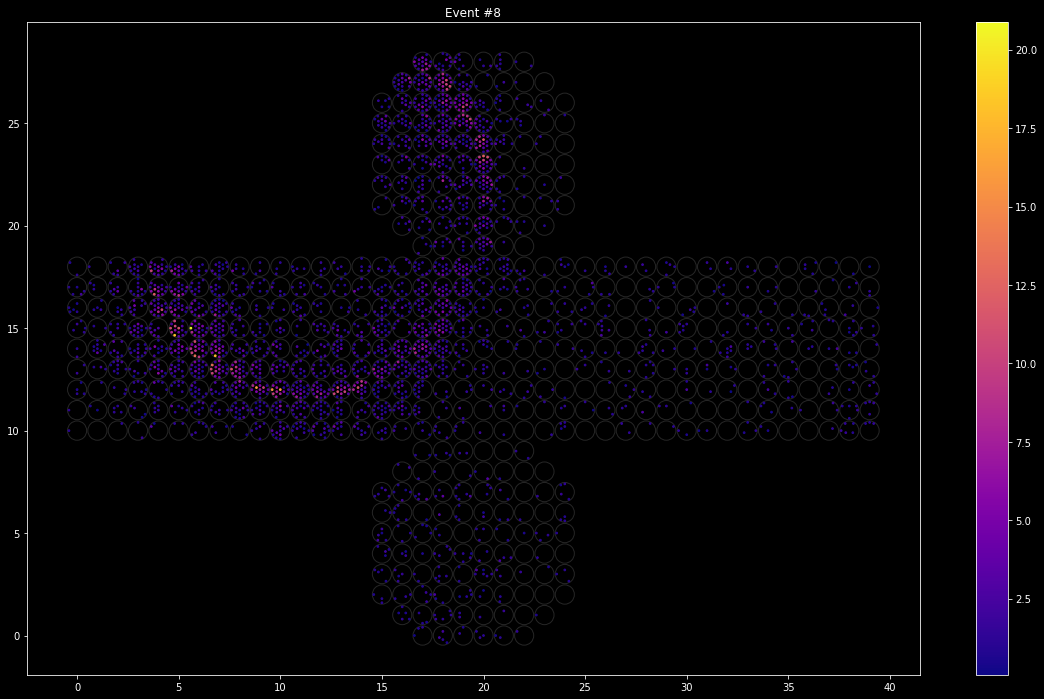

In [10]:
data_short = data_obj.__getitem__(8)['data']
plot_event(data_short, data_obj.mpmt_positions, title="Event #8", style="dark_background", cmap=plt.cm.plasma)

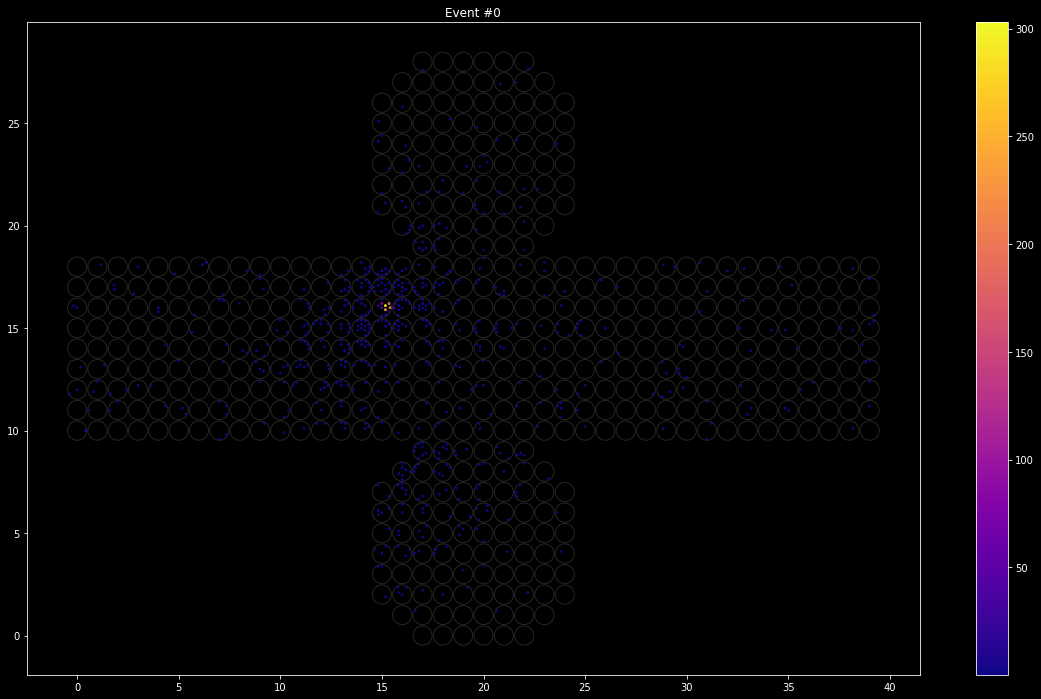

In [11]:
data_short = data_obj.__getitem__(0)['data']
plot_event(data_short, data_obj.mpmt_positions, title="Event #0", style="dark_background", cmap=plt.cm.plasma)

In [12]:
file_len = np.array(data_file['positions']).shape[0]

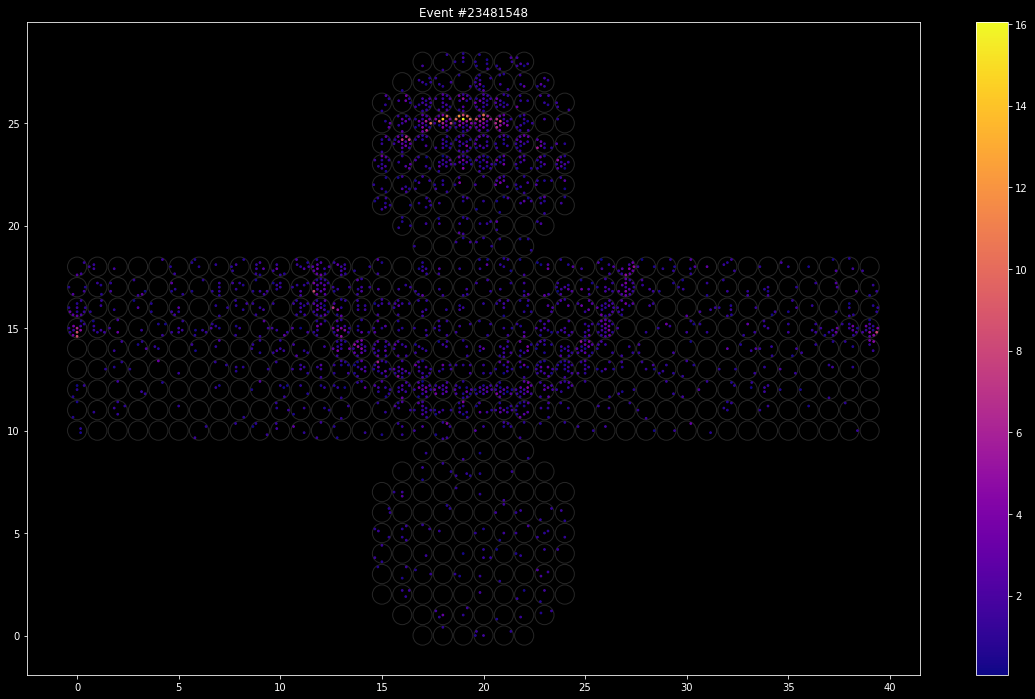

In [13]:
data_short = data_obj.__getitem__(file_len-1)['data']
plot_event(data_short, data_obj.mpmt_positions, title="Event #{}".format(file_len-1), style="dark_background", cmap=plt.cm.plasma)

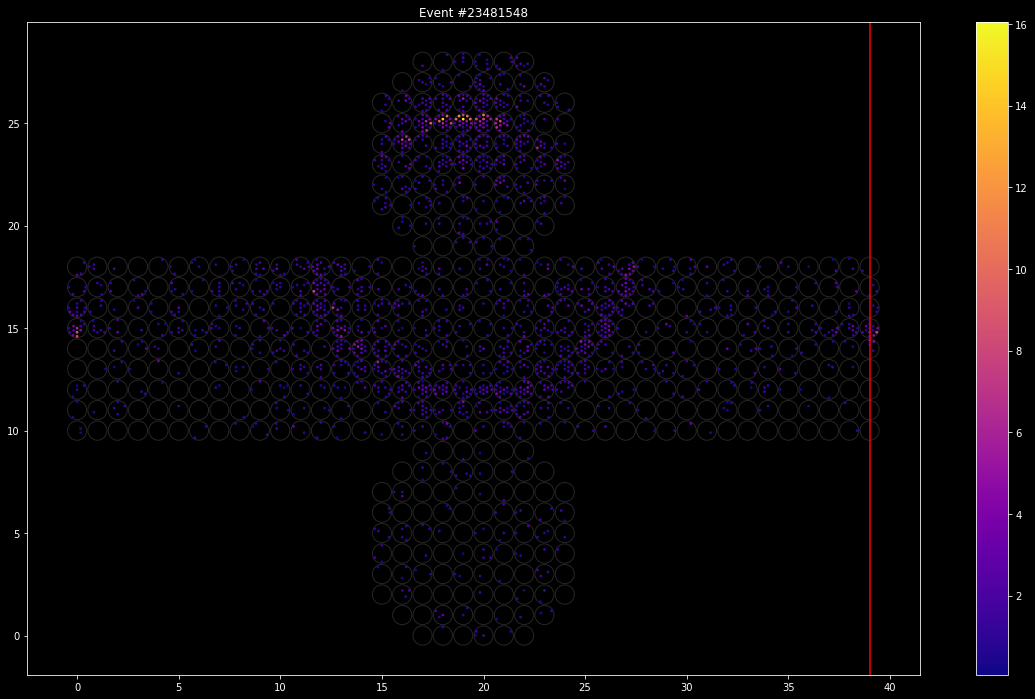

In [14]:
data_short = data_obj.__getitem__(file_len-1)['data']
plot_event(data_short, data_obj.mpmt_positions, title="Event #{}".format(file_len-1), style="dark_background", cmap=plt.cm.plasma,
          vertical_partition=True)

In [15]:
data_obj.__getitem__(1)

{'labels': 1,
 'energies': array([855.76855], dtype=float32),
 'angles': array([1.1681432, 2.5514793], dtype=float32),
 'positions': array([[-117.36474,  108.4042 , -311.18503]], dtype=float32),
 'event_ids': 1,
 'root_files': b'/localscratch/prouse.56905527.0/WCSim/e-/E0to1000MeV/unif-pos-R400-y300cm/4pi-dir/IWCD_mPMT_Short_e-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir_3000evts_0.root',
 'indices': 1,
 'data': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
      

Height: 29, Width: 40, and 19 pixels for each PMT

In [16]:
data_short.shape

torch.Size([19, 29, 40])

In [17]:
data_short[:, :, :20].shape

torch.Size([19, 29, 20])

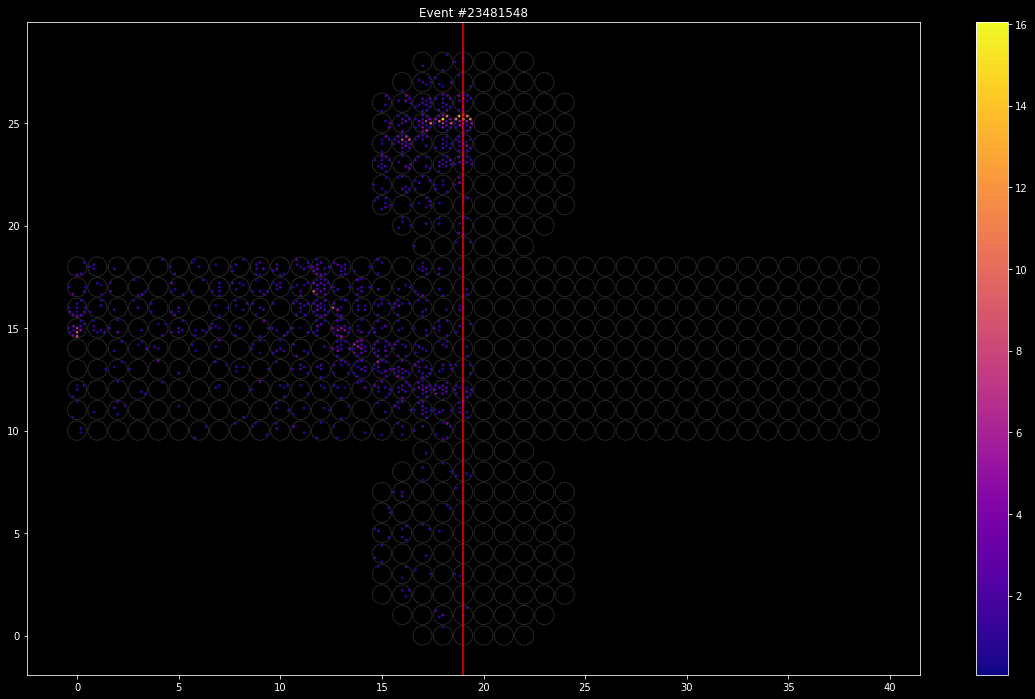

In [18]:
plot_event(data_short[:, :, :20], data_obj.mpmt_positions, title="Event #{}".format(file_len-1), style="dark_background", cmap=plt.cm.plasma,
          vertical_partition=True)

<h2>Create Padding</h2>

In [19]:
horiz_pad_data = data_short.clone()

In [20]:
horiz_pad_data.shape

torch.Size([19, 29, 40])

In [21]:
data_short.clone()[:, :, :20].shape

torch.Size([19, 29, 20])

In [22]:
half_len_index = int(data_short.shape[2]/2)

In [23]:
horiz_pad_data = torch.cat((horiz_pad_data, torch.zeros_like(data_short.clone()[:, :, :half_len_index])), 2)

In [24]:
horiz_pad_data.shape

torch.Size([19, 29, 60])

In [25]:
horiz_pad_data[:, :, 2*half_len_index:] = torch.tensor(np.nan, dtype=torch.float64)

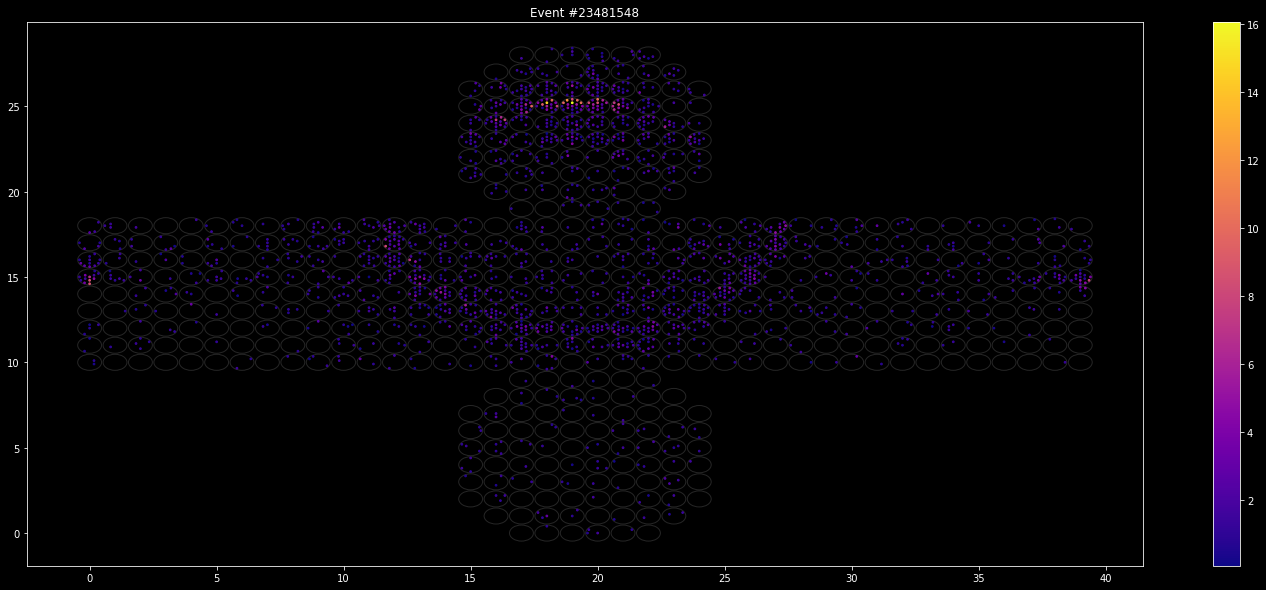

In [26]:
plot_event(horiz_pad_data, data_obj.mpmt_positions, title="Event #{}".format(file_len-1), style="dark_background", cmap=plt.cm.plasma,
        padded=True)

In [27]:
barrel_rows = data_obj.barrel_rows

In [28]:
data_short.clone()[:, barrel_rows, :half_len_index].shape

torch.Size([19, 9, 20])

In [29]:
horiz_pad_data[:, barrel_rows, 2*half_len_index:].shape

torch.Size([19, 9, 20])

In [30]:
horiz_pad_data[:, barrel_rows, 2*half_len_index:] = data_short.clone()[:, barrel_rows, :half_len_index]

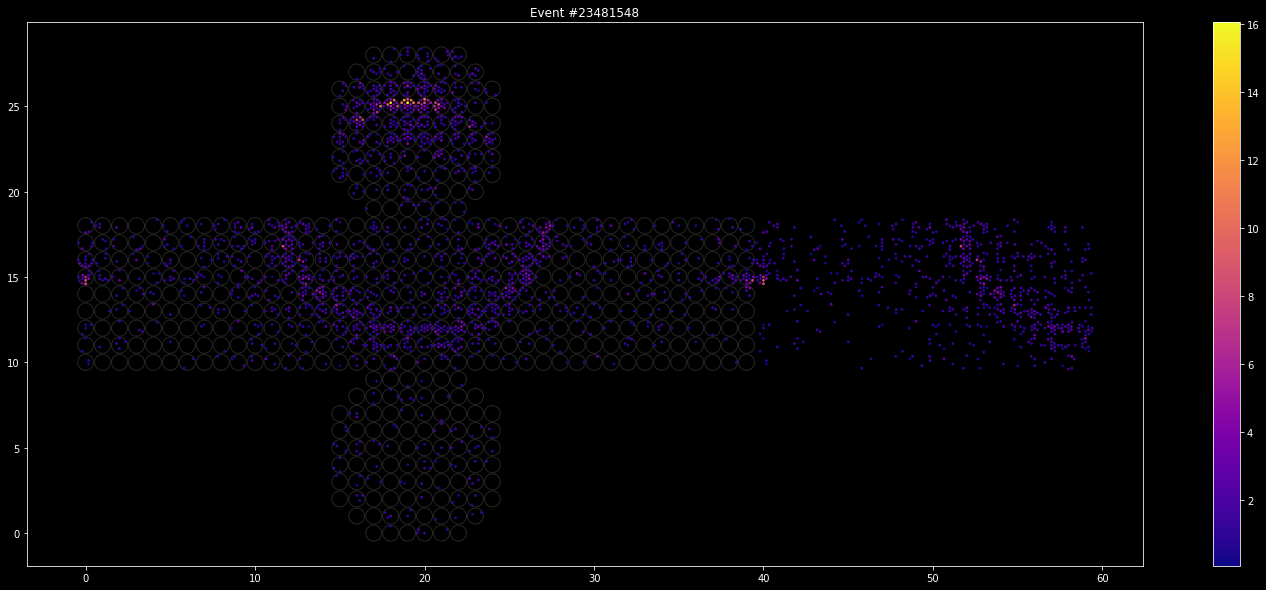

In [31]:
plot_event(horiz_pad_data, data_obj.mpmt_positions, title="Event #{}".format(file_len-1), style="dark_background", cmap=plt.cm.plasma,
        padded=True)

<h1>Endcaps</h1>

<h2>Top Endcap</h2>

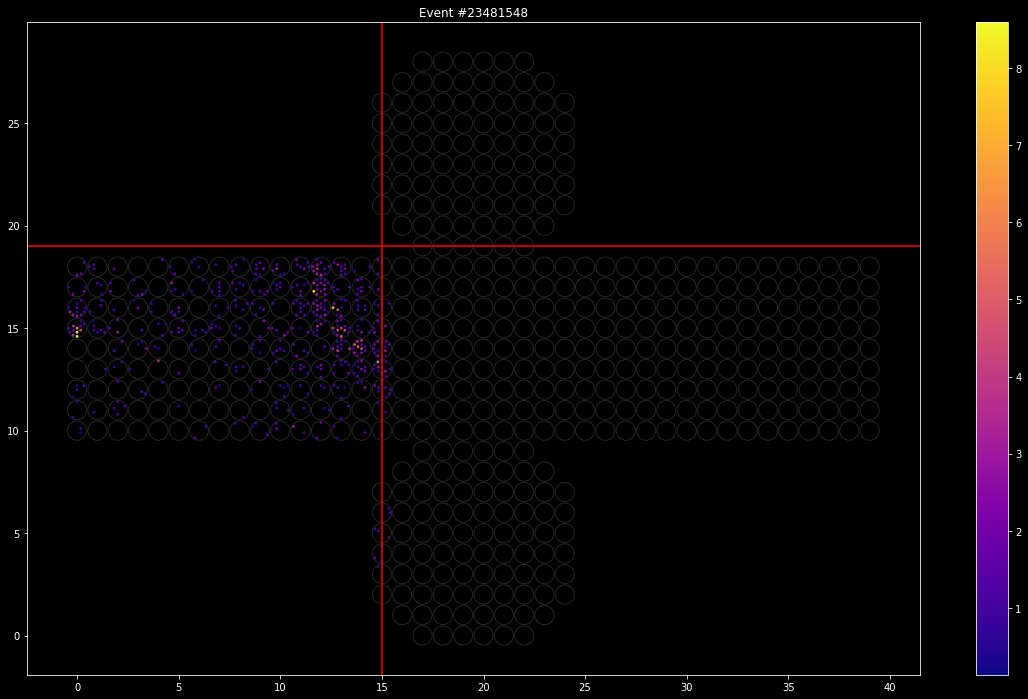

In [32]:
plot_event(data_short[:, :barrel_rows[-1]+2, :16], data_obj.mpmt_positions, title="Event #{}".format(file_len-1), style="dark_background", cmap=plt.cm.plasma,
          vertical_partition=True, horizontal_partition=True)

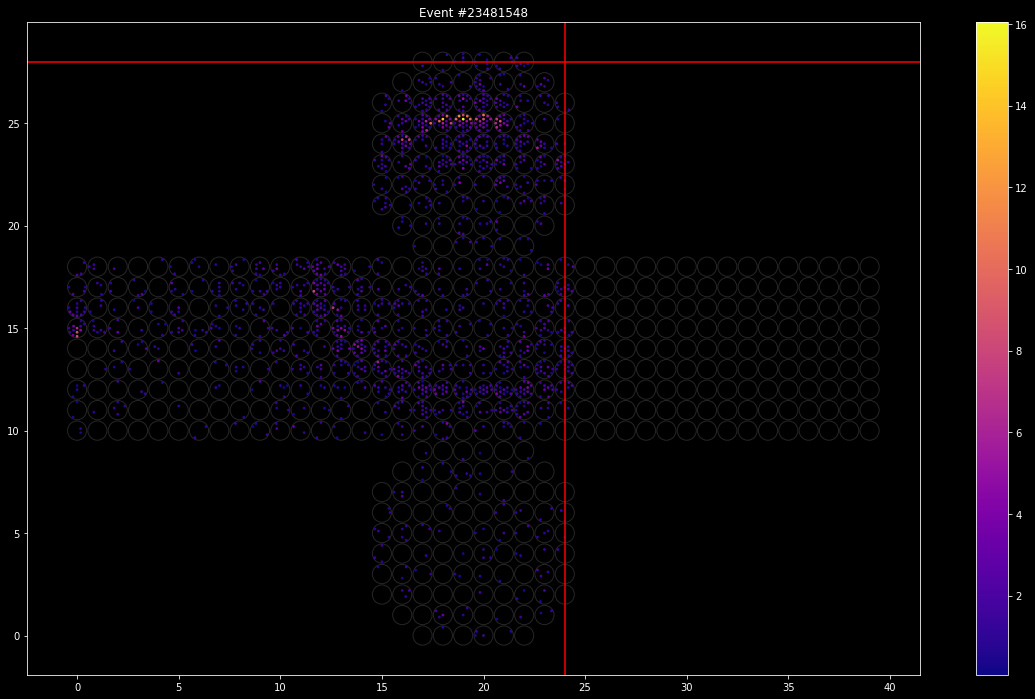

In [33]:
plot_event(data_short[:, :barrel_rows[-1]+12, :25], data_obj.mpmt_positions, title="Event #{}".format(file_len-1), style="dark_background", cmap=plt.cm.plasma,
          vertical_partition=True, horizontal_partition=True)

<h2>Bottom Endcap</h2>

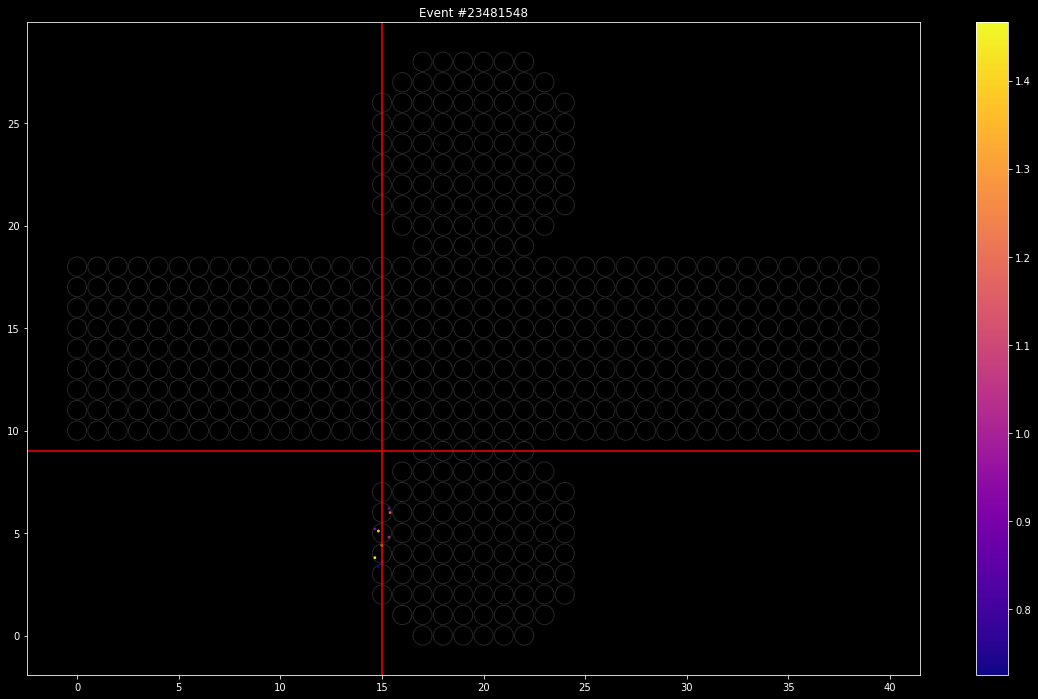

In [34]:
plot_event(data_short[:, :barrel_rows[0], :16], data_obj.mpmt_positions, title="Event #{}".format(file_len-1), style="dark_background", cmap=plt.cm.plasma,
          vertical_partition=True, horizontal_partition=True)

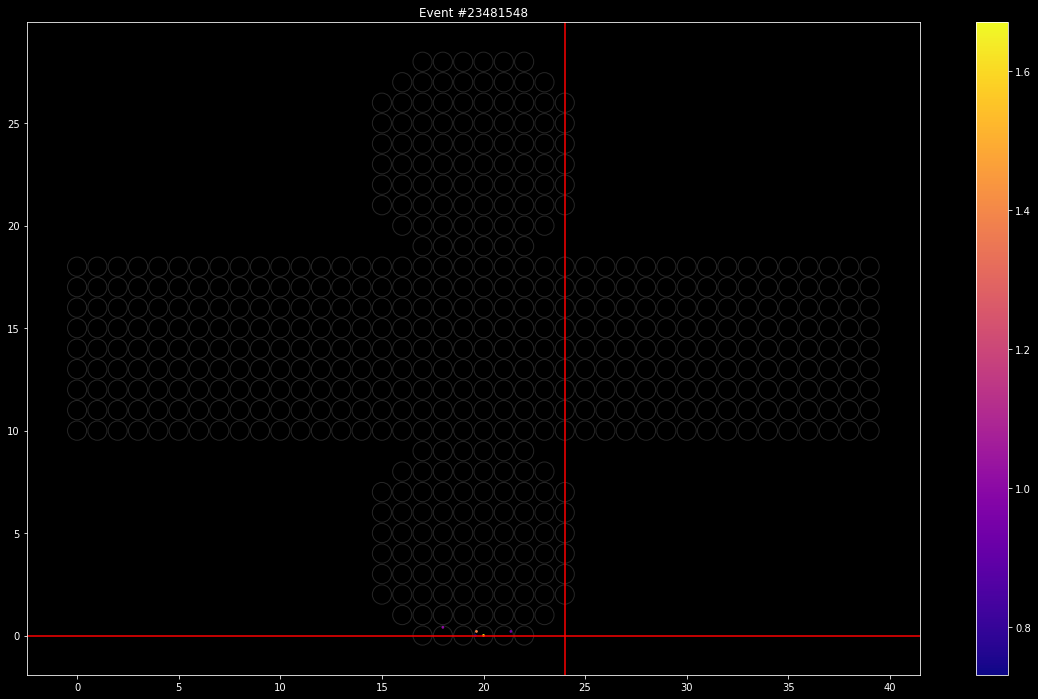

In [35]:
plot_event(data_short[:, :barrel_rows[0]-9, :25], data_obj.mpmt_positions, title="Event #{}".format(file_len-1), style="dark_background", cmap=plt.cm.plasma,
          vertical_partition=True, horizontal_partition=True)

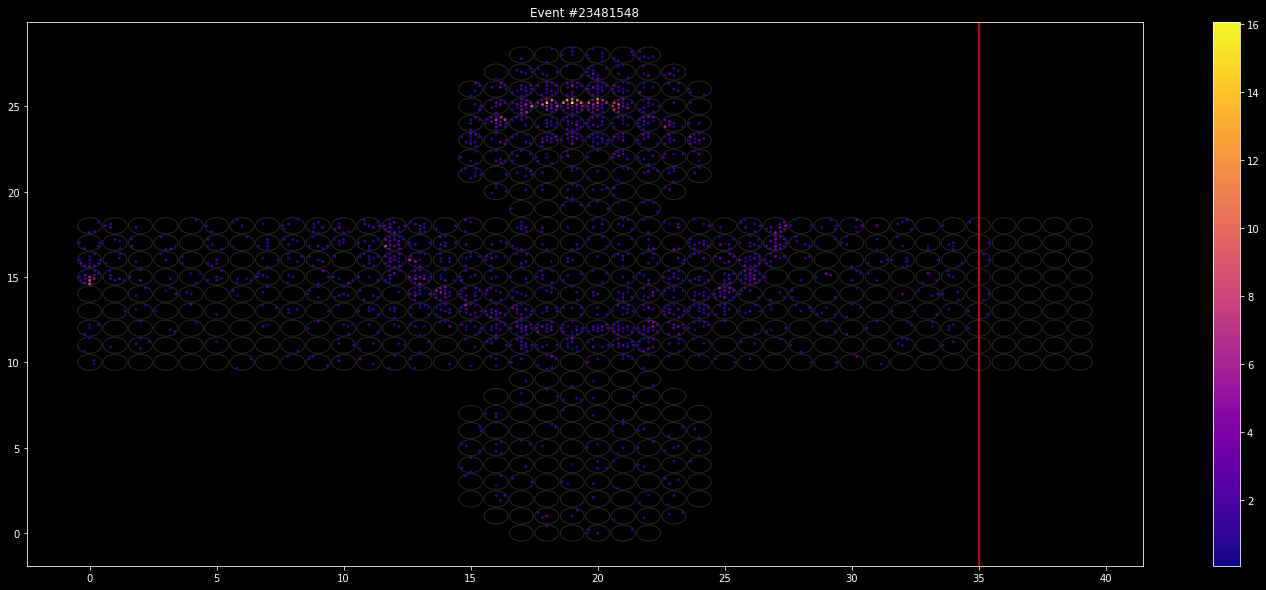

In [36]:
plot_event(horiz_pad_data[:, :, :36], data_obj.mpmt_positions, title="Event #{}".format(file_len-1), style="dark_background", cmap=plt.cm.plasma,
        padded=True, vertical_partition=True)

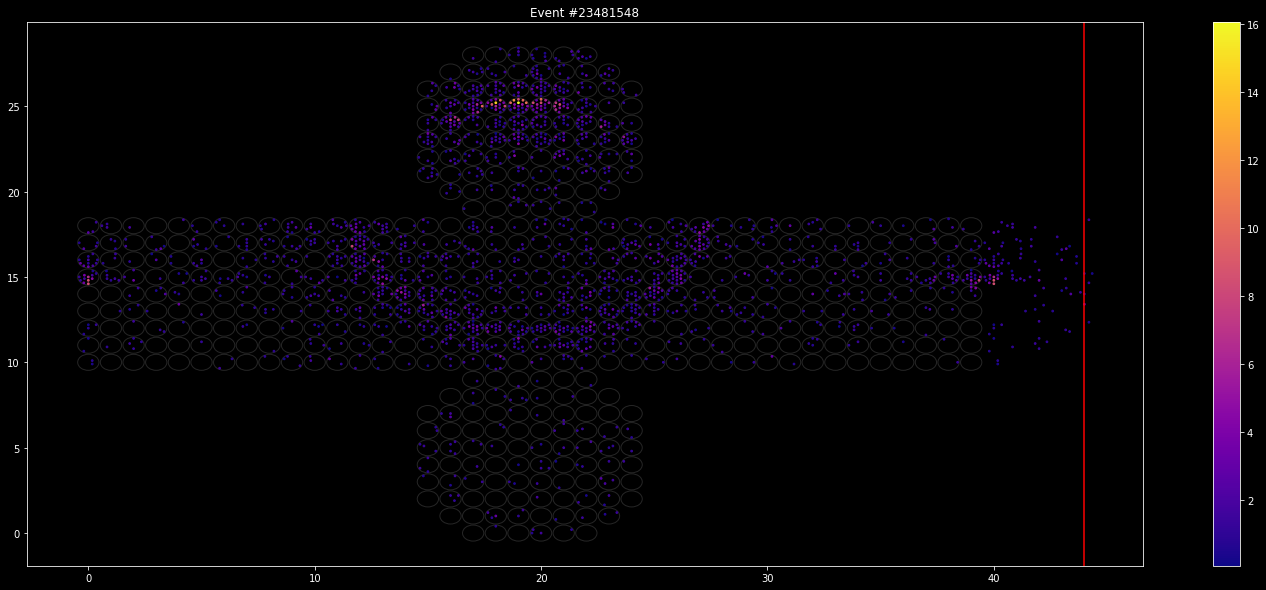

In [37]:
plot_event(horiz_pad_data[:, :, :45], data_obj.mpmt_positions, title="Event #{}".format(file_len-1), style="dark_background", cmap=plt.cm.plasma,
        padded=True, vertical_partition=True)

In [38]:
l_index = data_short.shape[2]/2 - 1
r_index = data_short.shape[2]/2

In [39]:
l_endcap_ind = int(l_index - 4)
r_endcap_ind = int(r_index + 4)

In [40]:
r_endcap_ind + data_short.shape[2]/2

44.0

In [41]:
top_end_cap = data_short.clone()[:, barrel_rows[-1]+1:, l_endcap_ind:r_endcap_ind+1]

In [42]:
bot_end_cap = data_short.clone()[:, :barrel_rows[0], l_endcap_ind:r_endcap_ind+1]

<h2>Apply Vertical Transformations</h2>

In [43]:
from watchmal.dataset.cnn_mpmt.transformations import vertical_flip

In [44]:
vflip_top = vertical_flip(top_end_cap)
vlfip_bot = vertical_flip(bot_end_cap)

In [45]:
horiz_pad_data[:, barrel_rows[-1]+1:, l_endcap_ind + int(data_short.shape[2]/2) : r_endcap_ind + int(data_short.shape[2]/2) + 1] = vflip_top
horiz_pad_data[:, :barrel_rows[0], l_endcap_ind + int(data_short.shape[2]/2) : r_endcap_ind + int(data_short.shape[2]/2) + 1] = vlfip_bot

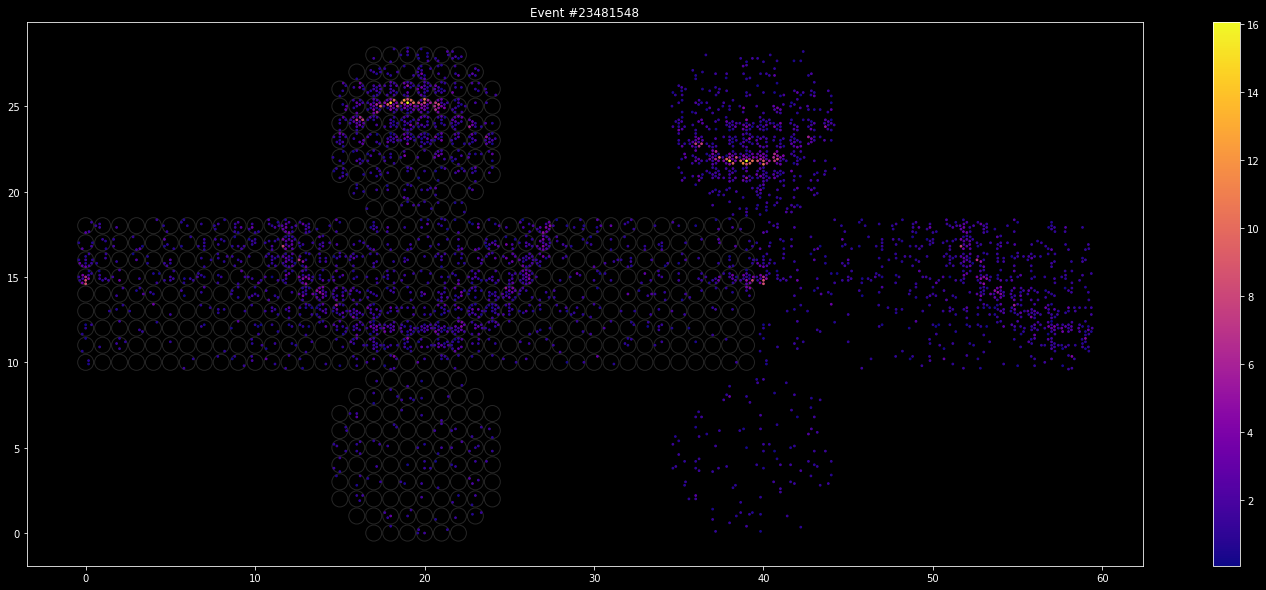

In [46]:
plot_event(horiz_pad_data, data_obj.mpmt_positions, title="Event #{}".format(file_len-1), style="dark_background", cmap=plt.cm.plasma,
        padded=True)

<h1>Testing <Code>mpmtPadding</Code> Tranformation</h1>

In [47]:
from watchmal.dataset.cnn_mpmt.transformations import mpmtPadding

<h3>Non-Padded Data</h3>

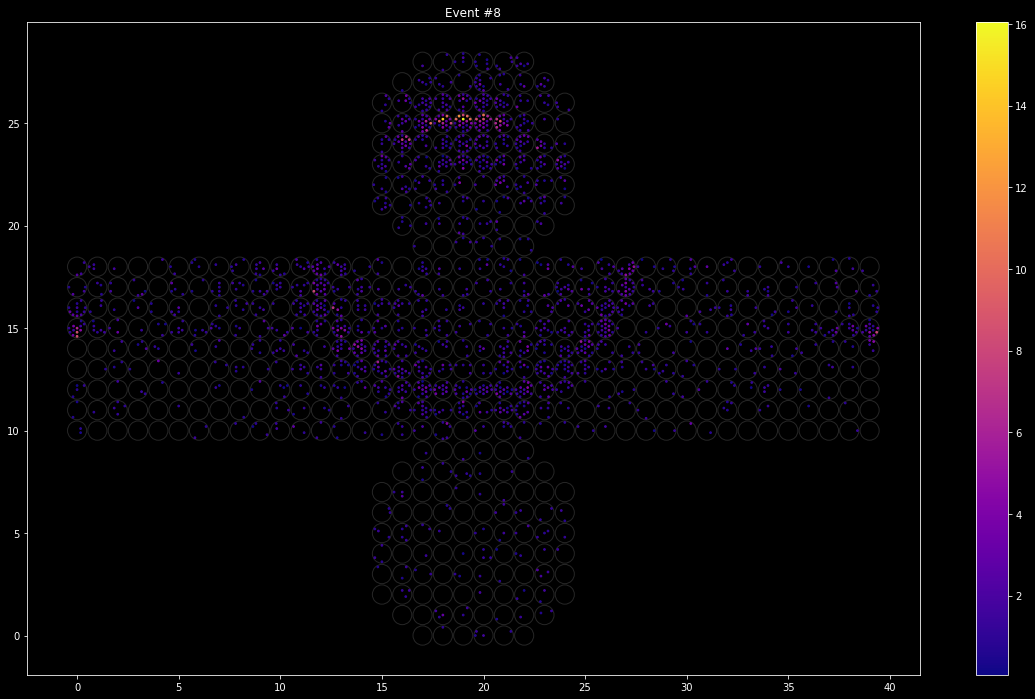

In [48]:
plot_event(data_short, data_obj.mpmt_positions, title="Event #8", style="dark_background", cmap=plt.cm.plasma)

<h3>Padded Data</h3>

In [49]:
padded_mpmt_data = mpmtPadding(data_short, data_obj.barrel_rows)

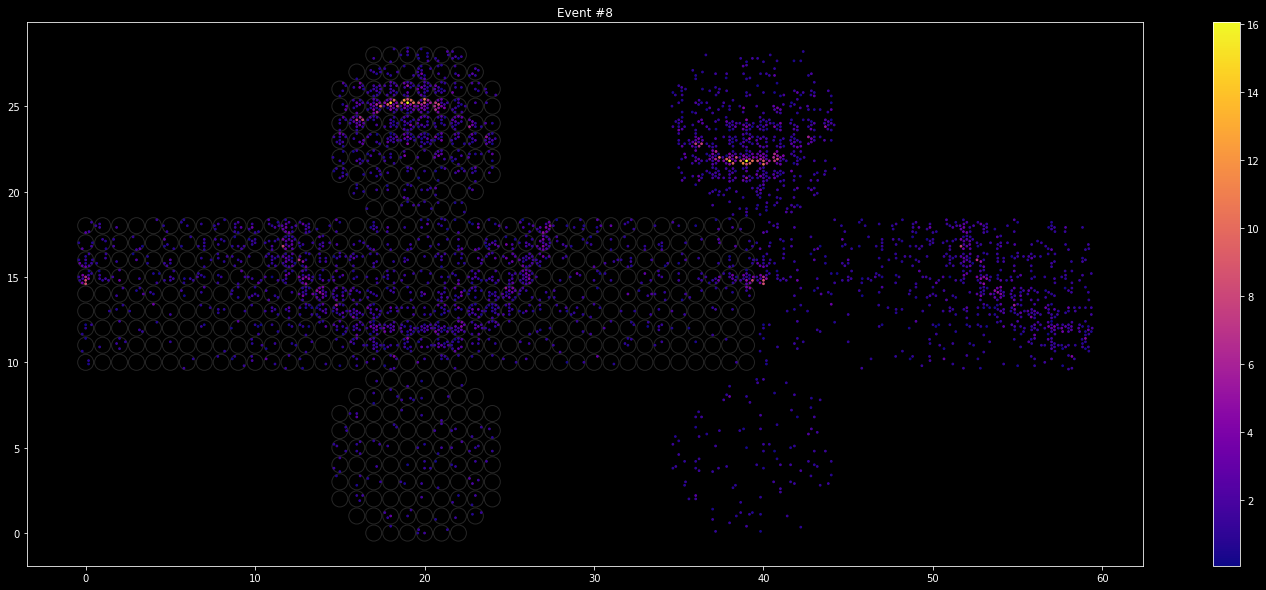

In [51]:
plot_event(padded_mpmt_data, data_obj.mpmt_positions, title="Event #8", style="dark_background", cmap=plt.cm.plasma,
          padded=True)